### This is a second notebook due to environment issues

In [3]:
import numpy as np
import lab3_tools as tools
import lab3_proto as proto
import lab1_proto as proto1
import lab1_tools as tools1
import lab2_proto as proto2
import lab2_tools as tools2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import np_utils
from keras.utils import np_utils

%reload_ext autoreload
%autoreload 2

In [4]:
stateList = np.load("stateList.npy", allow_pickle=True).tolist()

# 4.6 continuation

## Data conversion

In [5]:
output_dim = len(stateList)
#----
trainFile = np.load("flatDataTrain.npz")
lmfcc_train_x=trainFile["lmfcc_train_x"].astype('float32')
mspec_train_x=trainFile["mspec_train_x"].astype('float32')
dlmfcc_train_x=trainFile["dlmfcc_train_x"].astype('float32')
dmspec_train_x=trainFile["dmspec_train_x"].astype('float32')
train_y=np_utils.to_categorical(trainFile["train_y"],output_dim)
#print(lmfcc_train_x.shape,mspec_train_x.shape,dlmfcc_train_x.shape,dmspec_train_x.shape,train_y.shape) #| Shapes checked and OK
#----
valFile = np.load("flatDataVal.npz")
lmfcc_val_x=valFile["lmfcc_val_x"].astype('float32')
mspec_val_x=valFile["mspec_val_x"].astype('float32')
dlmfcc_val_x=valFile["dlmfcc_val_x"].astype('float32')
dmspec_val_x=valFile["dmspec_val_x"].astype('float32')
val_y=np_utils.to_categorical(valFile["val_y"],output_dim)
#print(lmfcc_val_x.shape,mspec_val_x.shape,dlmfcc_val_x.shape,dmspec_val_x.shape,val_y.shape)
#----
testFile = np.load("flatDataTest.npz")
lmfcc_test_x=testFile["lmfcc_test_x"].astype('float32')
mspec_test_x=testFile["mspec_test_x"].astype('float32')
dlmfcc_test_x=testFile["dlmfcc_test_x"].astype('float32')
dmspec_test_x=testFile["dmspec_test_x"].astype('float32')
test_y=np_utils.to_categorical(testFile["test_y"],output_dim)
#print(lmfcc_test_x.shape,mspec_test_x.shape,dlmfcc_test_x.shape,dmspec_test_x.shape,test_y.shape)

# 5. Phoneme Recognition with Deep Neural Networks

In [31]:
features = lmfcc_train_x
labels = train_y

features_val_lmfcc = lmfcc_val_x
features_val_mspec = mspec_val_x
features_val_dlmfcc = dlmfcc_val_x
features_val_dmspec = dmspec_val_x
labels_val = val_y

feature_dim = features.shape[1]
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(80,activation=tf.nn.relu,input_shape=(feature_dim,)))
model.add(tf.keras.layers.Dense(70,activation=tf.nn.relu)) #choose ReLu since it's faster to compute compared to Sigmoid
model.add(tf.keras.layers.Dense(output_dim,activation=tf.nn.softmax)) #softmax distributes probabilitites across our states

model.compile(loss="categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1120      
_________________________________________________________________
dense_1 (Dense)              (None, 70)                5670      
_________________________________________________________________
dense_2 (Dense)              (None, 61)                4331      
Total params: 11,121
Trainable params: 11,121
Non-trainable params: 0
_________________________________________________________________


In [117]:
#EPOCHS = 2 #Goes through data set EPOCHS number of times 
#BATCH_SIZE = 256 #Each training step model will see BATCH_SIZE number of examples to guide and adjust parameters

#model.fit(features,labels,epochs=EPOCHS,batch_size=BATCH_SIZE)

In [32]:
EPOCHS = 2
BATCH_SIZE = 256
print("On lmfcc model")
model_lmfcc = proto.trainDNN(lmfcc_train_x,train_y,EPOCHS,BATCH_SIZE)
print("On mspec model")
model_mspec = proto.trainDNN(mspec_train_x,train_y,EPOCHS,BATCH_SIZE)
print("On dlmfcc model")
model_dlmfcc = proto.trainDNN(dlmfcc_train_x,train_y,EPOCHS,BATCH_SIZE)
print("On dmspec model")
model_dmspec = proto.trainDNN(dmspec_train_x,train_y,EPOCHS,BATCH_SIZE)

#model_dmspec.save("model_dmspec")

On lmfcc model
Epoch 1/2
5264/5264 [==============================] - 6s 1ms/step - loss: 2.4185 - accuracy: 0.3628
Epoch 2/2
5264/5264 [==============================] - 6s 1ms/step - loss: 1.7489 - accuracy: 0.4807
On mspec model
Epoch 1/2
5264/5264 [==============================] - 7s 1ms/step - loss: 2.3883 - accuracy: 0.3476
Epoch 2/2
5264/5264 [==============================] - 6s 1ms/step - loss: 1.8973 - accuracy: 0.4393
On dlmfcc model
Epoch 1/2
5264/5264 [==============================] - 7s 1ms/step - loss: 1.9342 - accuracy: 0.4584
Epoch 2/2
5264/5264 [==============================] - 6s 1ms/step - loss: 1.3629 - accuracy: 0.5759
On dmspec model
Epoch 1/2
5264/5264 [==============================] - 9s 2ms/step - loss: 1.9336 - accuracy: 0.4499
Epoch 2/2
5264/5264 [==============================] - 7s 1ms/step - loss: 1.3754 - accuracy: 0.5750


### Purpose of validation data? 

- Training data: Used to created weights of neural network
- Validation data: Used to compare different neural networks and choose the one that gives best result
- Test data: Simply used to test performance of the trained and chosen neural network. If not good results, start over. 

If you use the training and validation data as the same, the choice of neural network can be biased. Which means that the neural network was chosen as better just for that data. Real world data mighjt not have that connection to the neural network and might therefore not perform well. 

This is why the comparison of models is performed on validation data below

In [33]:
val_loss_lmfcc, val_acc_lmfcc = model_lmfcc.evaluate(features_val_lmfcc,labels_val)
print("val_acc_lmfcc:",val_acc_lmfcc) #Can increase with more epochs and more sofisticated model
print("val_loss_lmfcc:",val_loss_lmfcc)
val_loss_mspec, val_acc_mspec = model_mspec.evaluate(features_val_mspec,labels_val)
print("val_acc_mspec:",val_acc_mspec) #Can increase with more epochs and more sofisticated model
print("val_loss_mspec:",val_loss_mspec)
val_loss_dlmfcc, val_acc_dlmfcc = model_dlmfcc.evaluate(features_val_dlmfcc,labels_val)
print("val_acc_dlmfcc:",val_acc_dlmfcc) #Can increase with more epochs and more sofisticated model
print("val_loss_dlmfcc:",val_loss_dlmfcc)
val_loss_dmspec, val_acc_dmspec = model_dmspec.evaluate(features_val_dmspec,labels_val)
print("val_acc_dmspec:",val_acc_dmspec) #Can increase with more epochs and more sofisticated model
print("val_loss_dmspec:",val_loss_dmspec)

4996/4996 [==============================] - 3s 623us/step - loss: 1.6840 - accuracy: 0.4940
val_acc_lmfcc: 0.4940285086631775
val_loss_lmfcc: 1.6839789152145386
4996/4996 [==============================] - 3s 613us/step - loss: 1.8078 - accuracy: 0.4626
val_acc_mspec: 0.4626477360725403
val_loss_mspec: 1.8077961206436157
4996/4996 [==============================] - 3s 645us/step - loss: 1.2677 - accuracy: 0.6018
val_acc_dlmfcc: 0.6018092632293701
val_loss_dlmfcc: 1.2677197456359863
4996/4996 [==============================] - 3s 654us/step - loss: 1.2667 - accuracy: 0.6034
val_acc_dmspec: 0.6034108400344849
val_loss_dmspec: 1.266711950302124


## 5.1 Detailed Evaluation

Looking at the results above, we can see that the best model according to the validation data is the dynamic features. Since the dmspec is slighty better, that one will be chosen

In [18]:
model_dmspec = keras.models.load_model("model_dmspec")
#prediction = model_dmspec.predict(dmspec_test_x)
#np.save("predictionDmspecE2B256.npy",prediction)
prediction = np.load("predictionDmspecE2B256.npy")
print(type(prediction))
print(prediction.shape) #each row sums to 1
print(sum(prediction[8]))
print(test_y[456])

<class 'numpy.ndarray'>
(1527014, 61)
1.0000000092451684
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [121]:

for i in range(prediction.shape[0]):
    row = prediction[i,:]
    maxIndex = prediction[i,:].argmax()
    prediction[i,:] = np.zeros(row.shape)
    prediction[i,maxIndex] = 1

print(prediction[456])
    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Investigating an example utterance

(203, 61)


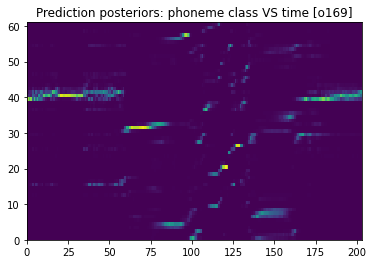

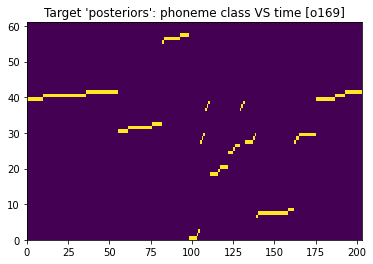

In [30]:
#unflattened data
testdata = np.load("testdataStand.npy",allow_pickle=True)
#o169
utterance_o169_dmspec = testdata[34]["mspecStacked"]
utterance_o169_targets = testdata[34]["targets"]

utterance_o169_targetsMatrix = proto._targetsFromIndex2z1Matrix(utterance_o169_targets)

#print(utterance_o169_targets.shape)
#print(testdata[34]["mspecStacked"].shape) #when dynamic features were genereated, dmspec was called mspecStacked
#print(proto.indexArray2stringArray(testdata[34]["targets"]))

#prediction
utterance_o169_prediction = model_dmspec.predict(utterance_o169_dmspec)
print(utterance_o169_prediction.shape)

plt.pcolormesh(utterance_o169_prediction.T)
plt.title("Prediction posteriors: phoneme class VS time [o169]")
plt.show()

plt.pcolormesh(utterance_o169_targetsMatrix.T)
plt.title("Target 'posteriors': phoneme class VS time [o169]")
plt.show()

In [36]:
print(stateList[39:41])
print(stateList[30:32])
print(stateList[58:60])
print(stateList[20:40])
print(stateList[8:10])
print(stateList[25:29])
print(stateList[39:41])

['sil_0', 'sil_1']
['ow_0', 'ow_1']
['z_0', 'z_1']
['ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0']
['ay_2', 'eh_0']
['k_1', 'k_2', 'n_0', 'n_1']
['sil_0', 'sil_1']


### 1. Frame-by-frame at state level

In [122]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

global_score = 0
max_score = prediction.shape[0]
for i in range(max_score):
    if (prediction[i] == test_y[i]).all():
        global_score += 1

print("global score is:", global_score/max_score)

#pred_list = proto.convert2indexArray(prediction)
#np.save("pred_listDmspecE2B256.npy",pred_list)
#print(pred_list)
#print("on test_y_list")
#test_y_list = proto.convert2indexArray(test_y)
#np.save("test_y_list.npy",test_y_list)
#conf_matr1 = confusion_matrix(test_y,prediction)
#disp1 = ConfusionMatrixDisplay(conf_matr1)
#disp1.plot()





global score is: 0.5887667041690515


In [9]:
pred_list = np.load("pred_listDmspecE2B256.npy")
test_y_list = np.load("test_y_list.npy")

pred_list_states = proto.indexArray2stringArray(pred_list)
test_y_list_states = proto.indexArray2stringArray(test_y_list)
print(test_y_list_states[345:349])

['ah_1', 'ah_1', 'ah_1', 'ah_2']


### 2. Frame-by-frame at phoneme level

In [147]:
phonemes = ['ow','z', 'iy', 'r','w', 'ah', 'n', 'uw','th','f', 'ao','ay', 'v','s', 'ih', 'k','eh','ey', 't','sil','sp']
print(pred_list_states[123:128])
#pred_list_phonemes = proto.stateArray2phonemeArray(pred_list_states)
#test_y_list_phonemes = proto.stateArray2phonemeArray(test_y_list_states)
#np.save("pred_list_phonemes.npy",pred_list_phonemes)
#np.save("test_y_list_phonemes.npy",test_y_list_phonemes)
#print(pred_list_phonemes[123:128])
#print(test_y_list_phonemes[123:128])

['sil_1', 'sil_2', 'sil_2', 'sil_1', 'sil_2']
['sil', 'sil', 'sil', 'sil', 'sil']
['s', 's', 's', 'sp', 'sp']


In [153]:
pred_list_phonemes = np.load("pred_list_phonemes.npy")
test_y_list_phonemes = np.load("test_y_list_phonemes.npy")

pred_list_phonemes = proto.mergePhonemes(pred_list_phonemes)
test_y_list_phonemes = proto.mergePhonemes(test_y_list_phonemes)

print(len(pred_list_phonemes))
print(len(test_y_list_phonemes))

global_score = 0
max_score = len(test_y_list_phonemes)
for i,phoneme in enumerate(test_y_list_phonemes): # OBS! different lengths, choose shortest
    if phoneme == pred_list_phonemes[i]:
        global_score += 1

print("global score is:", global_score/max_score)

251163
96749
global score is: 0.054997984475291736


### 3. Edit distance at the state level

In [152]:
pred_list_statesMerged = proto.mergePhonemes(pred_list_states)
test_y_list_statesMerged = proto.mergePhonemes(test_y_list_states)
print(pred_list_statesMerged[456:460])
print(test_y_list_statesMerged[456:460])

#PER = proto.levenshteinDistance(pred_list_statesMerged,test_y_list_statesMerged)
#print(PER)

PER1 = 160180

160180


### 4. Edit distance at the phoneme level

In [154]:
#PER = proto.levenshteinDistance(pred_list_phonemes,test_y_list_phonemes)
#print(PER)
PER2=160180

160180


## 5.2 Possible questions

- what is the influence of feature kind and size of input context window?
    - The input kind is important since that reveals the amount of "hidden data". Ex. the lmfcc has been stripped of some information compared to the mspecs. This can later be interpred by the hidden layers. 
    -   input context window refers to including previous and future time-steps in our model input. It's the way we use dynamic features. The larger the context window, the more unisolated data we feed the network with, which should produce better results. This is of course limited to get good computational results. (https://medium.com/mindboard/input-window-size-for-deep-recurrent-reinforcement-learning-4e5d2960756b) 
- what is the purpose of normalising (standardising) the input feature vectors depending on
the activation functions in the network?
    - Because otherwise some values that shouldn't activate the activation function will do so and vice versa. When normalising all values, one ensures that all data is represented in relation to each other.
    - Looking at what happens when one only normalises for each utterance, some parts of an utterance might trigger the activation function even though it wouldn't have if one normalised all utterances in relation to each other. This is why shorter utterances might be over represented when one only normalises for each utternace in isolation.
- what is the influence of the number of units per layer and the number of layers?
    - Number of units can be translated into resolution of hidden features.
    - Number of layers can ber translated into the different component division of the features. Ex. image of numbers, divide a 9 into a line and loop etc.
- what is the influence of the activation function (when you try other activation functions
than ReLU, you do not need to reach convergence in case you do not have enough time)
    - Computational convergence time.
- what is the influence of the learning rate/learning rate strategy?
    - You want a DNN that increases it's accuracy a lot for each epoch
- how stable are the posteriograms from the network in time?
    - See plots above
- how do the errors distribute depending on phonetic class?
    - Some phonetic classes seems to get "confused". Ex. z and s. 